In [ ]:
pip install torch torchvision

In [ ]:
import math

import torch

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

class GraphConvolution(Module):

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'


class GraphPreConvolution(Module):

    def __init__(self, output_dimension, number_nodes, number_classes, bias=True):
        super(GraphPreConvolution, self).__init__()
        self.output_dimension = output_dimension
        self.number_nodes = number_nodes
        self.weight = Parameter(torch.FloatTensor(output_dimension, number_nodes))
        if bias:
            self.bias = Parameter(torch.FloatTensor(number_classes))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        output = torch.mm(self.weight, input)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, number_nodes, width_times_heigth):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.gpc = GraphPreConvolution(width_times_heigth, number_nodes, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        x = self.gpc(x)
        #Maybe try removing the following comment
        #x = F.dropout(x, self.dropout, training=self.training)
        return F.log_softmax(x, dim=1)

In [ ]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim

from scipy.io import loadmat, savemat

##### Training settings
#parser = argparse.ArgumentParser()
#parser.add_argument('--no-cuda', action='store_true', default=False,
#                    help='Disables CUDA training.')
#parser.add_argument('--fastmode', action='store_true', default=True,
#                    help='Validate during training pass.')
#parser.add_argument('--seed', type=int, default=42, help='Random seed.')
##### Maybe you need to modify the number of epochs
#parser.add_argument('--epochs', type=int, default=200,
#                    help='Number of epochs to train.')
##### Most likely, you will need to change the learning rate
#parser.add_argument('--lr', type=float, default=0.01,
#                    help='Initial learning rate.')
#parser.add_argument('--weight_decay', type=float, default=5e-4,
#                    help='Weight decay (L2 loss on parameters).')
##### Maybe, we need also to change the number of hidden units
#parser.add_argument('--hidden', type=int, default=16,
#                    help='Number of hidden units.')
#parser.add_argument('--dropout', type=float, default=0.5,
#                    help='Dropout rate (1 - keep probability).')

#args = parser.parse_args()
cuda = torch.cuda.is_available()
#cuda = False
#args.cuda = not args.no_cuda and torch.cuda.is_available()

#np.random.seed(args.seed)
np.random.seed(42)
#torch.manual_seed(args.seed)
torch.manual_seed(42)
if cuda:
  torch.cuda.manual_seed(42)
#if args.cuda:
#  torch.cuda.manual_seed(args.seed)

##### Here you need to configure the following variables:
##### nfeat=1 this is the second dimension of the vector of polarity, i.e., 1
##### nclass= _____ you need to put the number of semantic labels we are classifying
##### number_nodes= _____ you need to put here the number of nodes of the adjacency matrices, I think you called it M in your code
##### width_times_height= _____ this is the multplication between the width and the heigth of the event-based data, i.e., the spatial dimensions of the camera.

model = GCN(nfeat=1,
            nhid=16,
            nclass= 3, #complete this
            dropout=0.5,
            number_nodes=38, #complete this
            width_times_heigth=260*346) #complete this

##### Optimizer, we are gonna use Adam. Notice we are using l2 regularization in all layers
optimizer = optim.Adam(model.parameters(),
                       lr=0.01, weight_decay=5e-4)

if cuda:
  model.cuda()

#for i in set_of_tensors_in_training_set:
  ###############
  ##### In this block of code, you need to put your code for the construction of the graph for each tensor i in the TRAINING set
  ###############
  #adj_

set_of_tensors_in_training_set = np.load('/content/drive/MyDrive/Labelling_data/content/adj_pol_lab.npy', allow_pickle=True)
train_t = []
loss_t = []
for epoch in range(10):
  print('Epoch ', epoch + 1)
  t = time.time()
  ##### The following for loop iterates in the TRAINING set of our semantic segmentation dataset
  ##### Please modify it accordingly
  ctr = 0
  for i in set_of_tensors_in_training_set:
    ###############
    ##### In this block of code, you need to put your code for the construction of the graph for each tensor i in the TRAINING set
    adj_matrix = i[0]
    ###############
    A = torch.FloatTensor(adj_matrix) #here you have the adjacency matrix
    tensor_ones = torch.ones(A.shape[0], 1)
    A_tilde_1 = A + torch.eye(A.shape[0])
    ##### The following is the filtering operation
    diag_elements_1 = torch.mm(A_tilde_1, tensor_ones)
    diag_elements_1 = torch.div(tensor_ones, torch.sqrt(diag_elements_1))
    D_tilde_1 = torch.diag(diag_elements_1.view(-1))
    A_tilde_1 = torch.spmm(D_tilde_1, torch.spmm(A_tilde_1, D_tilde_1))
    adj_1 = A_tilde_1
    ##### The vector 'features' contain the vector of polarities, the dimension should be N times 1,
    ##### where N is the number of nodes, I think you called it M in your code.
    features = i[1]
    features = np.reshape(features,(len(features),1))
    #print(features.shape)
    features = torch.FloatTensor(features)
    ##### The variable 'labels' should contain the matrix (width*heigth times number_clases), i.e., you need to vectorize the ground truth of tensor i.
    ##### Please modify the following line accordingly
    ##### Remember this is the ground truth corresponding to the tensor i, the current iteration
    #print(cuda)
    labels = torch.LongTensor(i[2])
    labels = torch.max(labels, 1)[1]
    if cuda:
      features = features.cuda()
      adj_1 = adj_1.cuda()
      labels = labels.cuda()
    ##### The following lines, we have the actual training procedure
    model.train() # We do this here, and not outside the FOR LOOP, because later we will include a VALIDATION set to see if we are overfitting
    optimizer.zero_grad()
    output = model(features, adj_1)
    print(output.size())
    loss_train = F.nll_loss(output, labels)
    loss_train.backward()
    optimizer.step()
    print(type(loss_train.item()))
    loss_t.append(loss_train.item())
    train_t.append(epoch * 100 + ctr)
    ##### In the following line we are gonna see the training loss, we need to do this to be sure our network is not diverging.
    print("Training results:",
          "loss= {:.4f}".format(loss_train.item()))
    ctr = ctr + 1
  ##### Here we are gonna see the time each epoch requires
  print("Total time elapsed per epoch: {:.4f}s".format(time.time() - t))

##### Once the network is trained, we need to test our trained model in the tensors of the TEST set.
##### To do that you need to put your network in evaluation mode with the following line of code.
#model.eval()
##### You need to make a FOR LOOP in the TEST set and do a similar loop as before, but let's try first to get the training loop.
##### Perhaps, we will need to use a part of the TRAINING set as VALIDATION to check overfitting. We can do that later.

Epoch  1
torch.Size([89960, 3])
<class 'float'>
Training results: loss= 1.2546
torch.Size([89960, 3])
<class 'float'>
Training results: loss= 1.2260
torch.Size([89960, 3])
<class 'float'>
Training results: loss= 1.2076
torch.Size([89960, 3])
<class 'float'>
Training results: loss= 1.1890
torch.Size([89960, 3])
<class 'float'>
Training results: loss= 1.1727
torch.Size([89960, 3])
<class 'float'>
Training results: loss= 1.1582
torch.Size([89960, 3])
<class 'float'>
Training results: loss= 1.1456
torch.Size([89960, 3])
<class 'float'>
Training results: loss= 1.1318
torch.Size([89960, 3])
<class 'float'>
Training results: loss= 1.1184
torch.Size([89960, 3])
<class 'float'>
Training results: loss= 1.1050
torch.Size([89960, 3])
<class 'float'>
Training results: loss= 1.0928
torch.Size([89960, 3])
<class 'float'>
Training results: loss= 1.0797
torch.Size([89960, 3])
<class 'float'>
Training results: loss= 1.0652
torch.Size([89960, 3])
<class 'float'>
Training results: loss= 1.0500
torch.Size(

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


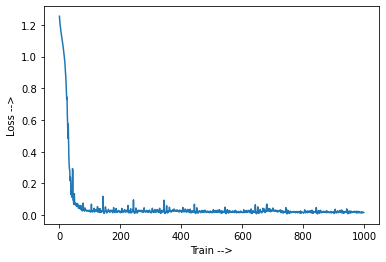

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_t, loss_t)
plt.xlabel('Train -->')
plt.ylabel('Loss -->')
plt.show()

In [ ]:
output.max()

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)

In [ ]:
output_gcn_vector = F.softmax(output)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [ ]:
output_gcn_vector.size()

torch.Size([89960, 3])

In [ ]:
prob_img=output_gcn_vector.cpu().detach().numpy()
print(prob_img.shape)

(89960, 3)


In [ ]:
max(output_img[0])

0.9838828

In [ ]:
def prob_to_lab(prob_img):
  lab_img = prob_img
  for i in range(len(prob_img)):
    for j in range(len(prob_img[i])):
      lab_img[i][j] = 1 if prob_img[i][j] == max(prob_img[i]) else 0
  return lab_img

In [ ]:
def lab_to_arr(lab_img):
  arr_img = []
  row = []
  for pixel in lab_img:
    if (pixel == [1, 0, 0]).all():
      row.append([0, 0, 0])
    elif (pixel == [0, 1, 0]).all():
      row.append([128, 128, 128])
    else:
      row.append([192, 128, 128])
    if len(row)%346 == 0:
      arr_img.append(row)
      row = []
  return arr_img
P = prob_img
print(P)
L = prob_to_lab(prob_img)
print(L)
A = lab_to_arr(L)
print(np.array(A,dtype='uint8').shape)
A[0][0]

[[0.99490106 0.00196773 0.00313122]
 [0.9945973  0.00210931 0.0032934 ]
 [0.9964439  0.00127116 0.00228493]
 ...
 [0.9970789  0.0009994  0.00192173]
 [0.9952182  0.00182087 0.00296083]
 [0.9917767  0.00348955 0.0047338 ]]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(260, 346, 3)


[0, 0, 0]

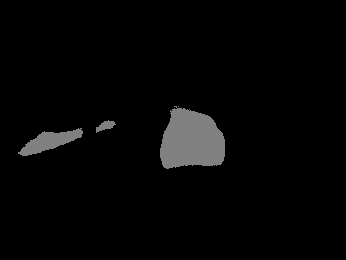

In [ ]:
from PIL import Image as im
def arr_to_img(arr_img):
  return im.fromarray(np.asarray(arr_img,dtype='uint8'))
I = arr_to_img(A)
I